<a href="https://colab.research.google.com/github/ogut77/DataScience/blob/main/CLTV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Lifetimes

     |████████████████████████████████| 584 kB 23.3 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import lifetimes

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df=pd.read_csv('/content/customer_segmentation.csv',encoding='cp1252')

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
 8   orderdate    541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 37.2+ MB


In [ ]:
df['Sales']=df['Quantity']*df['UnitPrice']

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,orderdate,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34


In [ ]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [ ]:
df['orderdate']=df['InvoiceDate'].map(lambda date: date.date())

In [ ]:
df['orderdate'].head()

0    2010-12-01
1    2010-12-01
2    2010-12-01
3    2010-12-01
4    2010-12-01
Name: orderdate, dtype: object

In [ ]:
df['orderdate'].describe()

count         541909
unique           305
top       2011-12-05
freq            5331
Name: orderdate, dtype: object

### **RFM matrix on transcations** 

In [ ]:
calibration_period_ends = '2011-09-05'

from lifetimes.utils import calibration_and_holdout_data

calib_holdout = calibration_and_holdout_data(df, 
                                                   customer_id_col = 'CustomerID', 
                                                   datetime_col = 'orderdate', 
                                                   freq = 'D', #days
                                        calibration_period_end=calibration_period_ends,
                                        observation_period_end='2011-12-9' )

In [ ]:
calib_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.0,0.0,0.0,230.0,0.0,95.0
12347.0,4.0,238.0,272.0,2.0,95.0
12348.0,2.0,110.0,263.0,1.0,95.0
12350.0,0.0,0.0,215.0,0.0,95.0
12352.0,3.0,34.0,201.0,3.0,95.0


### **Training model MBG/NBD**

In [ ]:
from lifetimes import ModifiedBetaGeoFitter

mbg_nbd = ModifiedBetaGeoFitter(penalizer_coef=0.01)
mbg_nbd.fit(calib_holdout['frequency_cal'], 
        calib_holdout['recency_cal'], 
        calib_holdout['T_cal'],
       verbose=True)

Optimization terminated successfully.
         Current function value: -2.032569
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29


<lifetimes.ModifiedBetaGeoFitter: fitted with 3388 subjects, a: 0.03, alpha: 54.07, b: 0.44, r: 0.80>

In [ ]:
print(mbg_nbd)

<lifetimes.ModifiedBetaGeoFitter: fitted with 3388 subjects, a: 0.03, alpha: 54.07, b: 0.44, r: 0.80>


Finding purchases & probablity of customer retention based on calibration and holdout summary

In [ ]:
t = 60 # days to predict in the future 
calib_holdout['predicted_purchases'] = mbg_nbd.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      calib_holdout['frequency_cal'], 
                                                                                      calib_holdout['recency_cal'], 
                                                                                      calib_holdout['T_cal'])

calib_holdout['p_alive'] = mbg_nbd.conditional_probability_alive(calib_holdout['frequency_cal'], 
                                                                         calib_holdout['recency_cal'], 
                                                                         calib_holdout['T_cal'])
calib_holdout['p_alive'] = np.round(calib_holdout['p_alive'] / calib_holdout['p_alive'].max(), 2)

In [ ]:
calib_holdout.head().T

CustomerID,12346.0,12347.0,12348.0,12350.0,12352.0
frequency_cal,0.000000,4.000000,2.000000,0.000000,3.000000
recency_cal,0.000000,238.000000,110.000000,0.000000,34.000000
T_cal,230.000000,272.000000,263.000000,215.000000,201.000000
frequency_holdout,0.000000,2.000000,1.000000,0.000000,3.000000
duration_holdout,95.000000,95.000000,95.000000,95.000000,95.000000
predicted_purchases,0.136299,0.871395,0.493376,0.145019,0.616727
p_alive,0.810000,0.990000,0.940000,0.820000,0.690000


In [ ]:
calib_holdout['predicted_purchases']*1000

CustomerID
12346.0     136.299177
12347.0     871.394866
12348.0     493.376083
12350.0     145.018526
12352.0     616.726589
              ...     
18280.0     168.219260
18281.0     302.066504
18282.0    1210.856181
18283.0    1772.223533
18287.0     259.092688
Name: predicted_purchases, Length: 3388, dtype: float64

Calculating raw summary without calibration and holdout

In [ ]:
raw_summary=lifetimes.utils.summary_data_from_transaction_data(df,'CustomerID','orderdate','Sales')
raw_summary.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


In [ ]:
#Excluding the negative values
raw_summary=raw_summary[raw_summary['monetary_value']>0]

### **Training Gamma-Gamma model**

In [ ]:
gg=lifetimes.GammaGammaFitter(penalizer_coef=0.01)
gg.fit(raw_summary['frequency'], 
       raw_summary['monetary_value'],time=1)
gg.summary

/usr/local/lib/python3.7/dist-packages/lifetimes/fitters/__init__.py:109: OptimizeWarning: Unknown solver options: time
  bounds=bounds,


,coef,se(coef),lower 95% bound,upper 95% bound
p,3.792282,0.096405,3.603328,3.981236
q,0.357821,0.007701,0.342727,0.372915
v,3.689081,0.097430,3.498119,3.880043


In [ ]:
raw_summary['predicted_clv']=gg.customer_lifetime_value(mbg_nbd,
                                                        raw_summary['frequency'], 
                                                        raw_summary['monetary_value'],
                                                        raw_summary['recency'], 
                                                        raw_summary['T'])
raw_summary.head()

,frequency,recency,T,monetary_value,predicted_clv
CustomerID,,,,,
12347.0,6.0,365.0,367.0,599.701667,2051.723548
12348.0,3.0,283.0,358.0,301.480000,1422.270407
12352.0,6.0,260.0,296.0,208.151667,2173.117069
12356.0,2.0,303.0,325.0,269.905000,920.409454
12358.0,1.0,149.0,150.0,683.200000,542.068750


**Plotting the frequency rate of transactions**

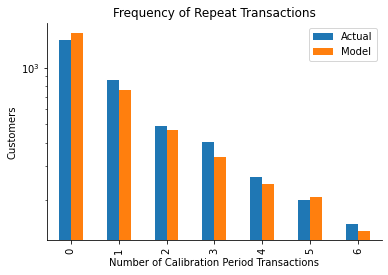

In [ ]:
from lifetimes.plotting import plot_period_transactions
ax = plot_period_transactions(mbg_nbd, max_frequency=7)
ax.set_yscale('log')
sns.despine();

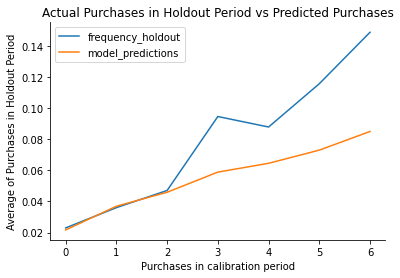

In [ ]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(mbg_nbd, calib_holdout)
sns.despine();

##**Calculating the probablity of customer retention**

In [ ]:
from lifetimes.plotting import plot_history_alive
from datetime import date
from pylab import figure, text, scatter, show
from lifetimes.utils import calculate_alive_path

In [ ]:
cust = calib_holdout.iloc[3265]
cust_id = cust.name
total = 365*90

In [ ]:
today = date.today()
ago = today.replace(year=today.year - 12)
now = today.replace(year=today.year + 1)

In [ ]:
tran = df.loc[df['CustomerID'] == cust_id]
total = (today - tran.orderdate.min()).days
p_alive_today = pd.DataFrame(calculate_alive_path(mbg_nbd, tran, 'orderdate', t, freq='D'))[0].tail(1).values
p_alive_today = np.round(p_alive_today[0], 2)
print('Probability that customer is alive today is', p_alive_today)

Probability that customer is alive today is [0.57]


In [ ]:
tran['orderdate']

483202    2011-11-20
483203    2011-11-20
483204    2011-11-20
Name: orderdate, dtype: object

Plotting the history of a particular customer with probablity alive

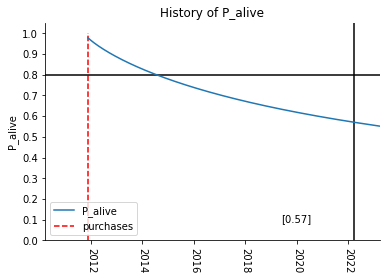

In [ ]:
total = (now - tran.orderdate.min()).days
ax = plot_history_alive(mbg_nbd, total, tran, 'orderdate', start_date=ago) 
ax.vlines(x=today, ymin=0, ymax=1.05 )
ax.hlines(y=0.8, xmin=ago, xmax=now )

ax.set_xlim(ago, now) 
ax.set_ylim(0, 1.05)

plt.xticks(rotation=-90)
text(0.75, 0.1, p_alive_today, ha='center', va='center', transform=ax.transAxes)

sns.despine()

## **Change of prediction according to time & plotting**

In [ ]:
from lifetimes.utils import expected_cumulative_transactions

In [ ]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'orderdate'],
      dtype='object')

In [ ]:
df1=df[['CustomerID','orderdate']]

In [ ]:
time_unit = (df1.orderdate.max() - df1.orderdate.min()).days
df2 = expected_cumulative_transactions(mbg_nbd, df1, 'orderdate', 'CustomerID', time_unit)


In [ ]:
df2.head()

,actual,predicted
0,0,1.423093
1,9,4.398410
2,15,8.077589
3,15,11.756162
4,23,16.411618


In [ ]:
from datetime import datetime

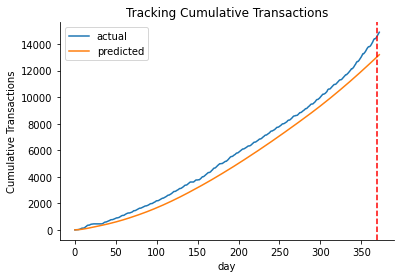

In [ ]:
cal = datetime.strptime('2011-12-05', '%Y-%m-%d')

from lifetimes.plotting import plot_cumulative_transactions
time_unit = (df1.orderdate.max() - df1.orderdate.min()).days
time_unit_cal = (cal.date() - df1.orderdate.min()).days
plot_cumulative_transactions(mbg_nbd, df1, 'orderdate', 'CustomerID', time_unit, time_unit_cal, freq='D')
sns.despine()

## **Plotting the tracking of daily transactions**

In [ ]:
from lifetimes.plotting import plot_incremental_transactions

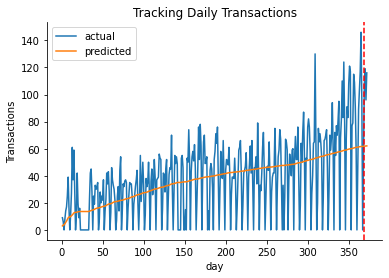

In [ ]:
plot_incremental_transactions(mbg_nbd, df1, 'orderdate', 'CustomerID', time_unit, time_unit_cal, freq='D')
sns.despine()